<a href="https://colab.research.google.com/github/sdlm/pytorch_mnist/blob/master/card_mask_unet_v07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import skimage.io as io
from tqdm import tqdm_notebook, tqdm

from skimage.draw import ellipse, polygon

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
import tensorflow as tf
import keras as keras

from keras import backend as K

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [0]:
h_size = 256
w_size = 256
train_num = 9500
train_x = np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = np.zeros((train_num, h_size, w_size, 1), dtype='float32')

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version
    A = A.numpy()
    B = B.numpy()
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)



from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss })
get_custom_objects().update({'dice_loss': dice_loss })
get_custom_objects().update({'dice_coef': dice_coef })
get_custom_objects().update({'my_iou_metric': my_iou_metric })


In [0]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


In [0]:
import re
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
ia.seed(1)

batch_size = 10
visible_batch_size = 4

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
sample_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_blur_256.jpg', pilmode="RGB")
mask_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_mask_inv_256.jpg', pilmode="RGB", as_gray=True)

original_smpl = np.array(sample_img, dtype=np.uint8)
original_mask = np.array(mask_img, dtype=np.uint8)
original_mask = original_mask.reshape(h_size, w_size, 1)

In [0]:
random_aug = iaa.SomeOf(3, [
    # Small blur
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0, 0.8)),
        iaa.AverageBlur(k=(0, 2)),
        iaa.MedianBlur(k=(1, 3)),
    ]),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.9, 1.1)),
    
    # Add gaussian noise.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.3),
    
    # Make some images brighter and some darker.
    iaa.Multiply((0.4, 1.7), per_channel=0.3),
    
    # Augmenter that sets rectangular areas within images to zero.
    iaa.CoarseDropout((0.0, 0.2), size_percent=(0.015, 0.3)),
], 
random_order=True
)

In [0]:
affine_aug = iaa.Sequential([
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        translate_px={"x": (-10, 10), "y": (-10, 10)},
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        rotate=(-20, 20),
        shear=(-30, 30),
        mode='wrap'
    )
]
)

In [0]:
def next_pair():
    _affine_aug = affine_aug._to_deterministic()
    _smpl = _affine_aug.augment_image(original_smpl)
    _smpl = random_aug.augment_image(_smpl)
    return _smpl, _affine_aug.augment_image(original_mask)

In [0]:
for k in range(train_num): # генерация всех img train
    img, msk = next_pair()
    train_x[k] = img / 255.0
    train_y[k] = msk / 255.0

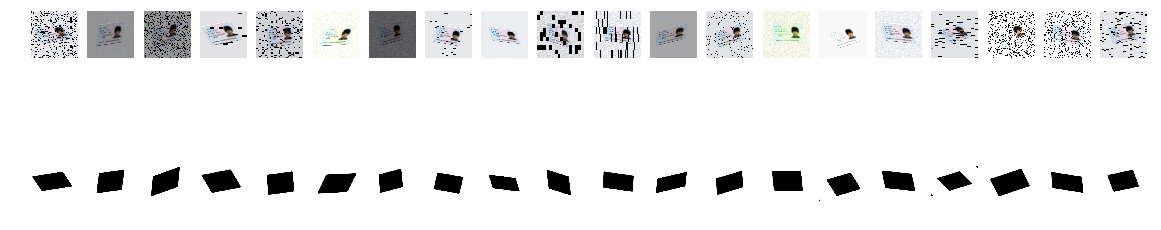

In [12]:
fig, axes = plt.subplots(2, 20, figsize=(20, 5)) # смотрим на первые 10 с масками
for k in range(20):
    axes[0, k].set_axis_off()
    axes[0, k].imshow(train_x[k])
    axes[1, k].set_axis_off()
    axes[1, k].imshow(train_y[k].squeeze())


In [13]:
input_layer = Input((h_size, w_size, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])
model.save_weights('./keras.weights')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
while True:
    history = model.fit(train_x, train_y,
                        batch_size=32,
                        epochs=1,
                        verbose=1,
                        validation_split=0.1
                       )
    if history.history['my_iou_metric'][0] > 0.97:
        break

Instructions for updating:
Use tf.cast instead.
Train on 8550 samples, validate on 950 samples
Epoch 1/1
8550/8550 [==============================] - 206s 24ms/step - loss: 0.4545 - my_iou_metric: 0.5455 - val_loss: 0.2616 - val_my_iou_metric: 0.7138
Train on 8550 samples, validate on 950 samples
Epoch 1/1
8550/8550 [==============================] - 196s 23ms/step - loss: 0.0787 - my_iou_metric: 0.9267 - val_loss: 0.0723 - val_my_iou_metric: 0.9431
Train on 8550 samples, validate on 950 samples
Epoch 1/1
8550/8550 [==============================] - 197s 23ms/step - loss: 0.0472 - my_iou_metric: 0.9744 - val_loss: 0.0434 - val_my_iou_metric: 0.9768


In [0]:
# genarate test image
test_num = 1
test_x = np.zeros((test_num, h_size, w_size, 3), dtype='float32')
for k in range(test_num): # генерация всех img train
    img, msk = next_pair()
    test_x[k] = img
test_x = test_x / 255.0

In [0]:
# predict mask
test_y = model.predict(test_x)

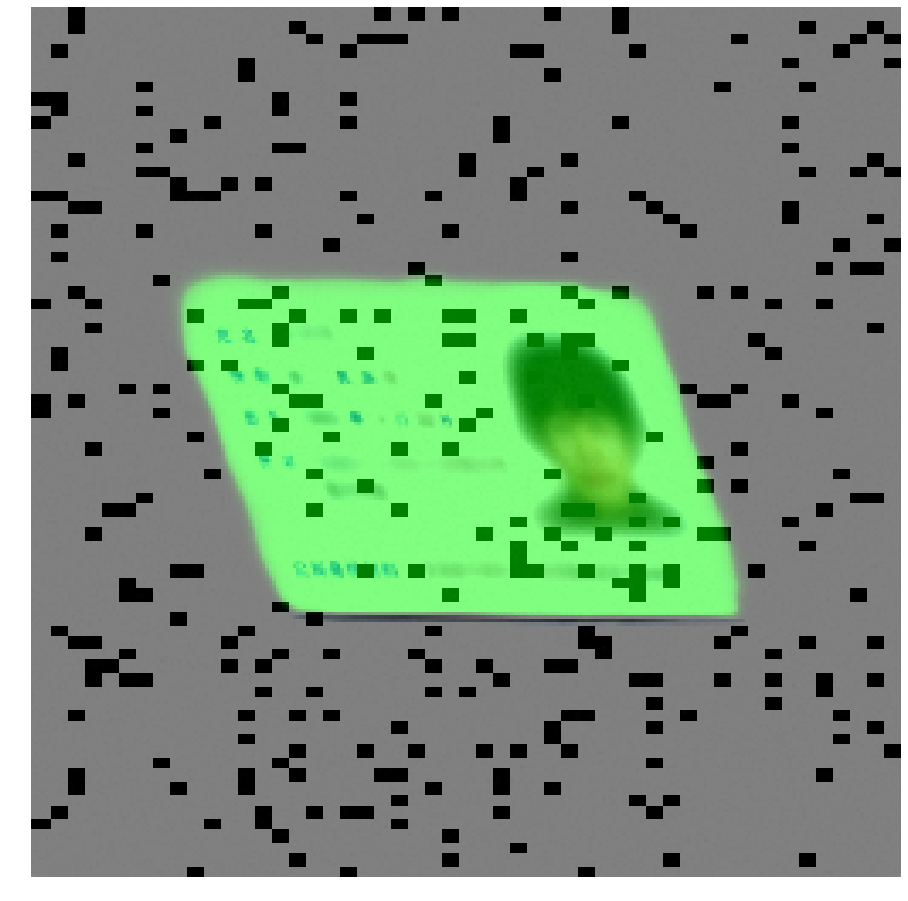

In [17]:
# show predict mask above test image
extent = 0, w_size, 0, h_size
fig = plt.figure(frameon=False, figsize=(16, 16))
im1 = plt.imshow(test_x[0], extent=extent)
plt.axis('off')
test_mask = test_y[0]
test_mask = test_mask.reshape(256, 256)
zero_layer = np.zeros((256, 256), dtype='float32')
stacked_img = np.stack((zero_layer, test_mask, zero_layer), axis=-1)
im2 = plt.imshow(stacked_img, alpha=0.5, extent=extent)

In [0]:
def genarate_test_image():
    test_x = np.zeros((h_size, w_size, 3), dtype='float32')
    img, msk = next_pair()
    test_x = img / 255.0
    return test_x

In [0]:
def show_predict_mask_above_image(test_image):
    test_x = np.zeros((1, h_size, w_size, 3), dtype='float32')
    test_x[0] = test_image
    
    # predict mask
    test_y = model.predict(test_x)
    
    # show predict mask above test image
    extent = 0, w_size, 0, h_size
    fig = plt.figure(frameon=False, figsize=(16, 16))
    im1 = plt.imshow(test_image, extent=extent)
    plt.axis('off')
    test_mask = test_y[0]
    test_mask = test_mask.reshape(256, 256)
    zero_layer = np.zeros((256, 256), dtype='float32')
    stacked_img = np.stack((zero_layer, test_mask, zero_layer), axis=-1)
    im2 = plt.imshow(stacked_img, alpha=0.5, extent=extent)

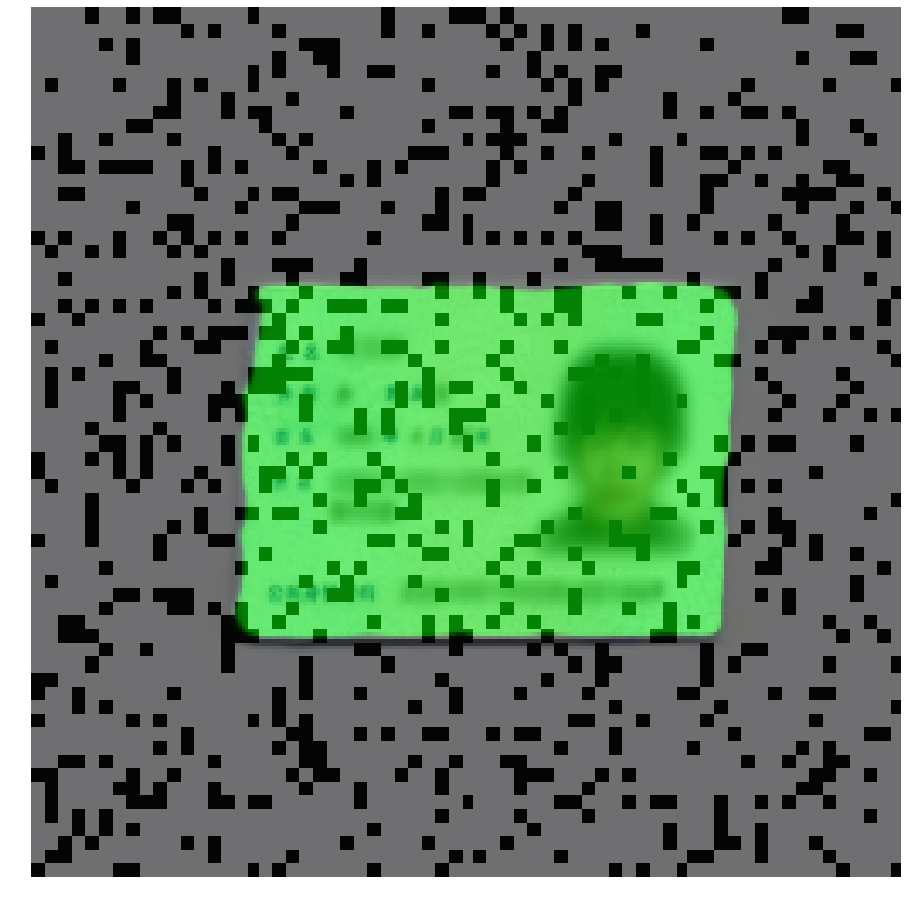

In [28]:
test_img = genarate_test_image()
show_predict_mask_above_image(test_img)

# TESTING ON NEW IMAGES

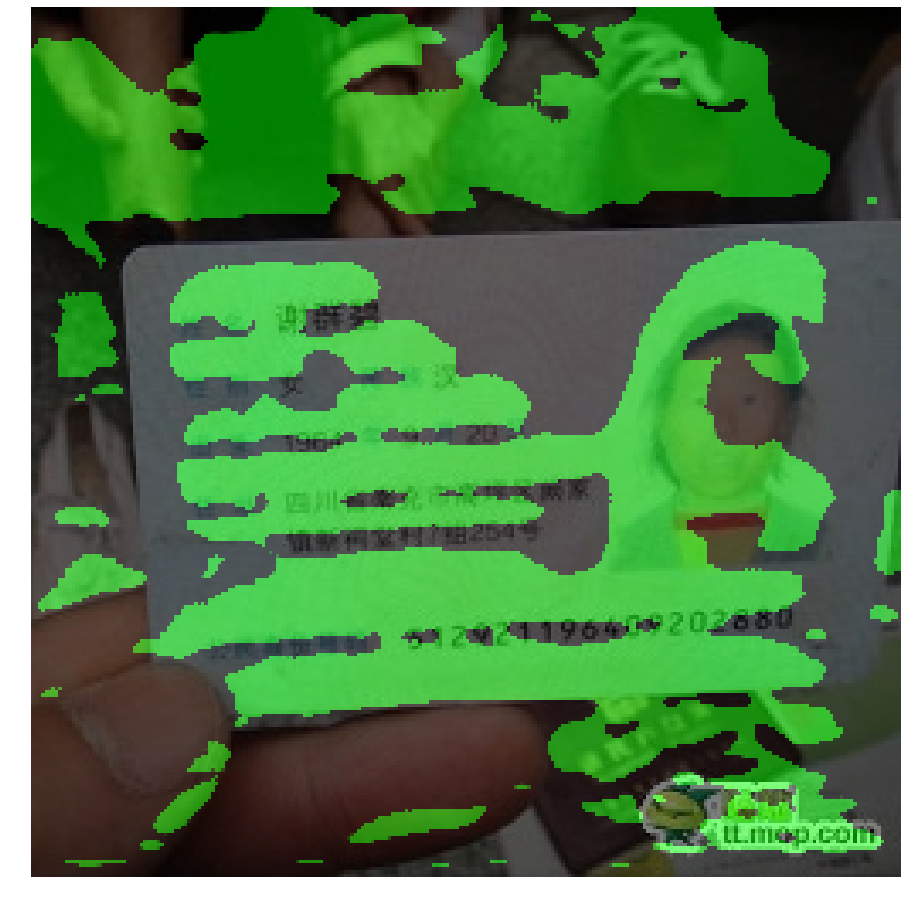

In [21]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/test/test_001.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

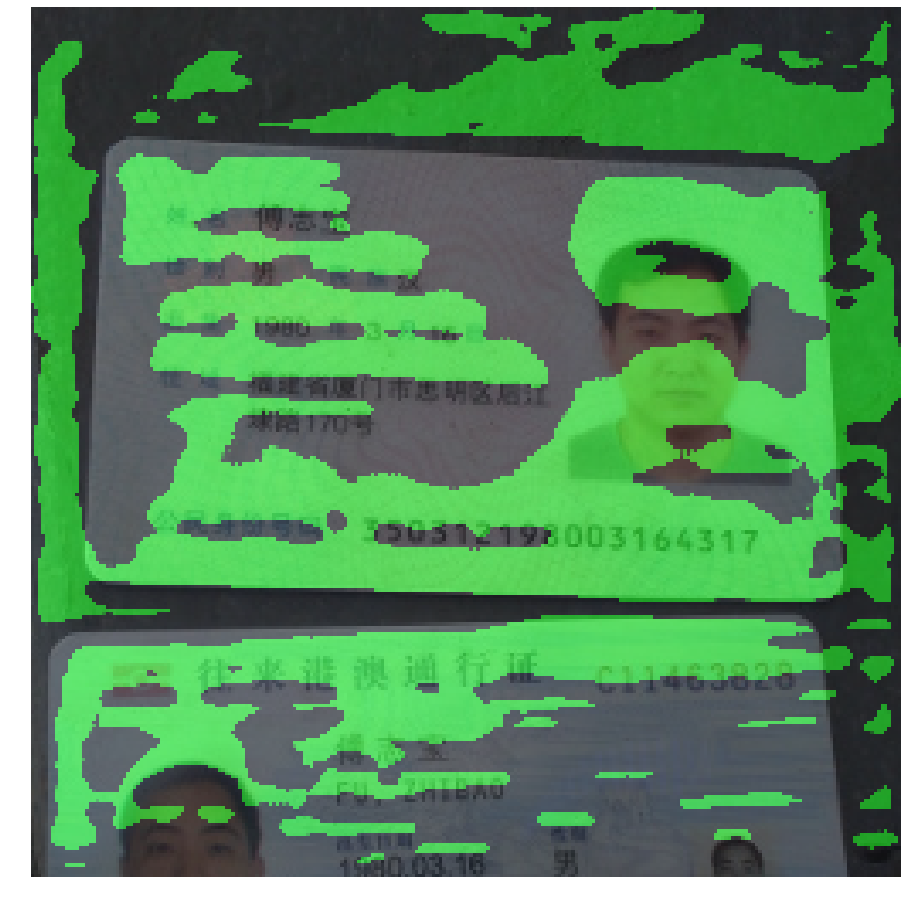

In [22]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/test/test_002.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)

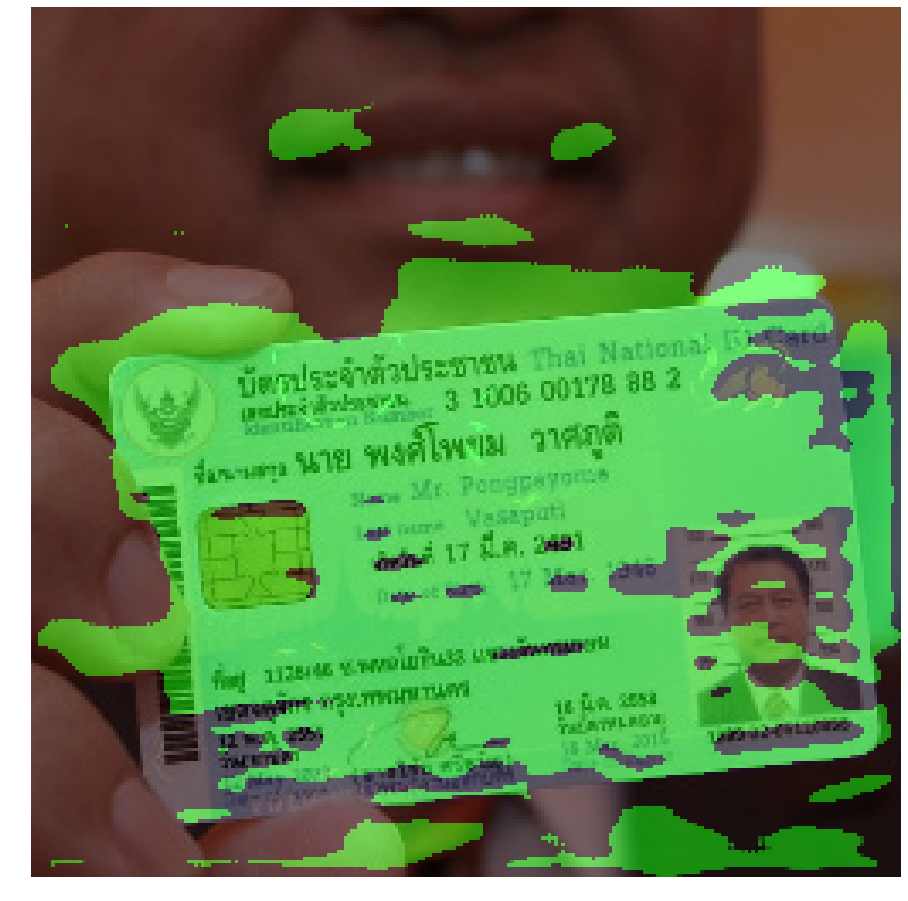

In [23]:
test_img = imageio.imread('/content/gdrive/My Drive/colab/test/test_003.jpg', pilmode="RGB")
test_arr = np.array(test_img, dtype=np.uint8)
show_predict_mask_above_image(test_arr)